# Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
test_target = pd.read_csv("Data/test_target.csv")

### Merge von test & train

In [3]:
merged_test = pd.merge(test, test_target, on="PetID", how="left")

In [4]:
combined = pd.concat([train, merged_test], axis=0, ignore_index=True)

### Daten überprüfung

In [5]:
train['Name'].nunique()

9059

In [6]:
print(train.dtypes)

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object


In [7]:
pd.set_option('display.max_columns', None)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

### Leere Zeilen füllen --> werden als leer gewertet

In [8]:
train.isna().sum()

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

### Spalte Namen löschen

In [9]:
combined = combined.drop(columns=['Name'])

### Vertielungen anschauen

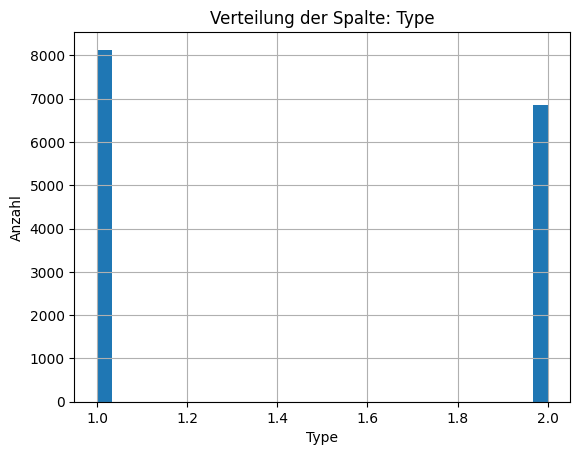

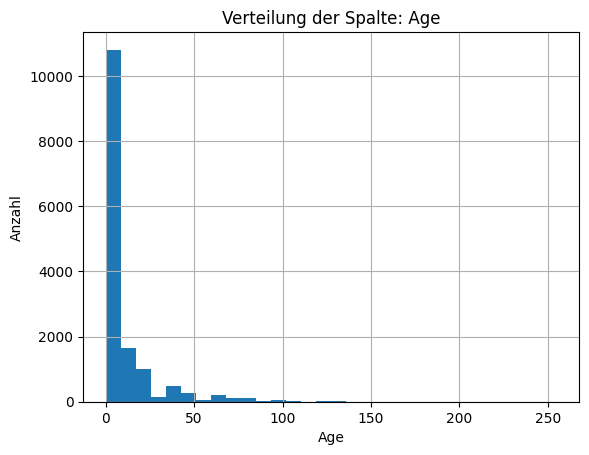

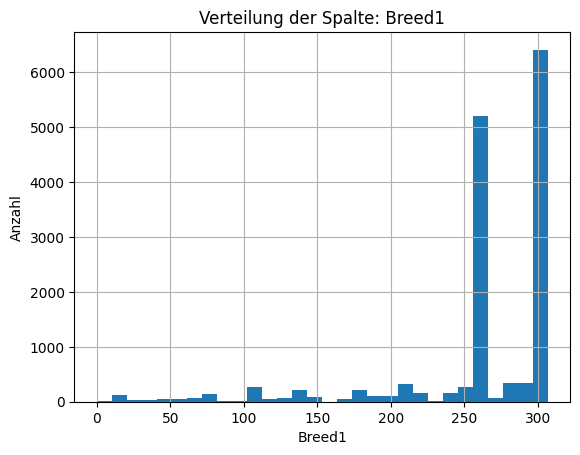

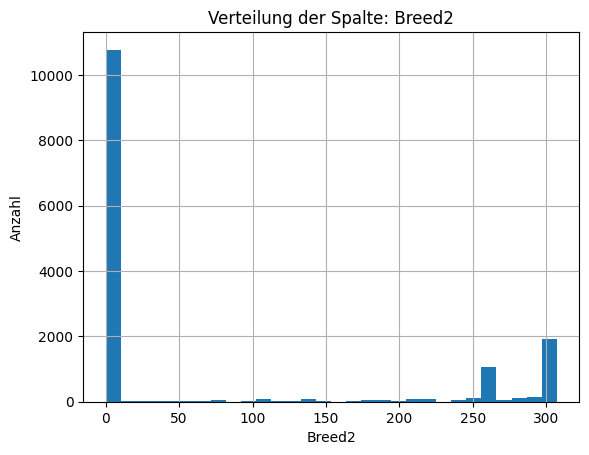

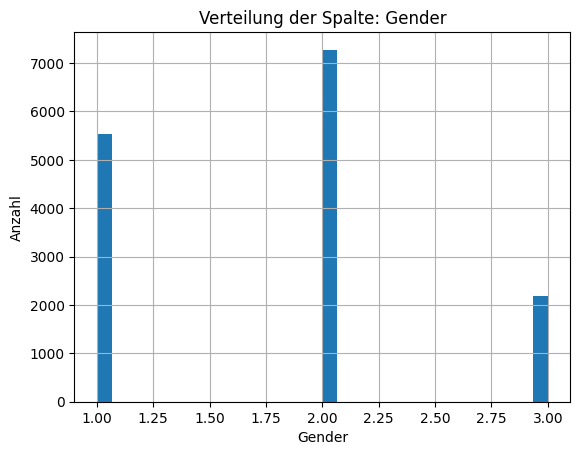

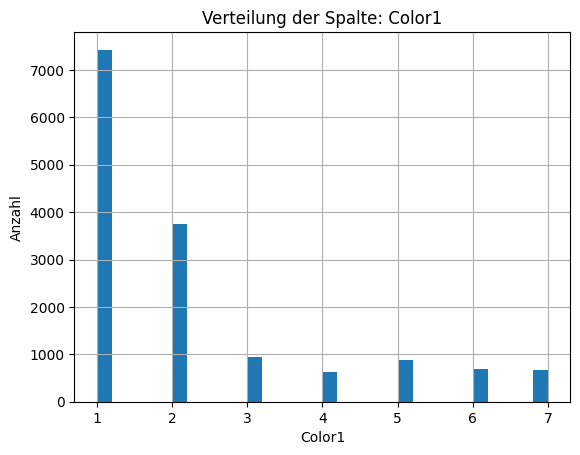

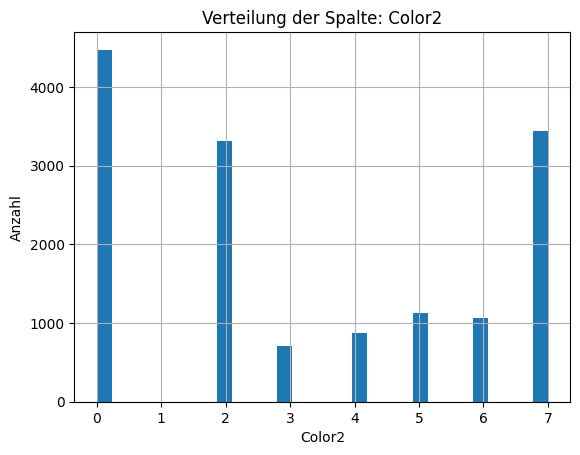

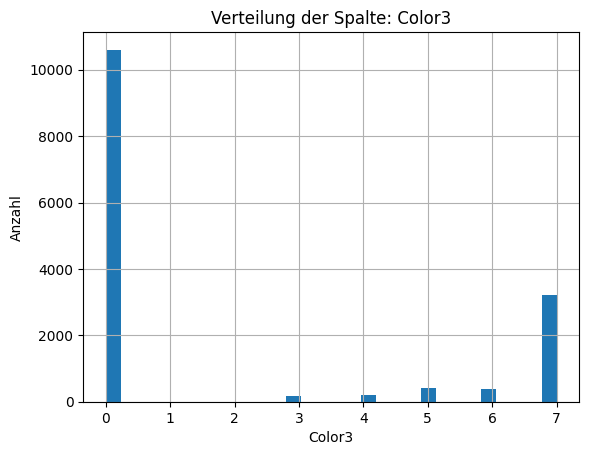

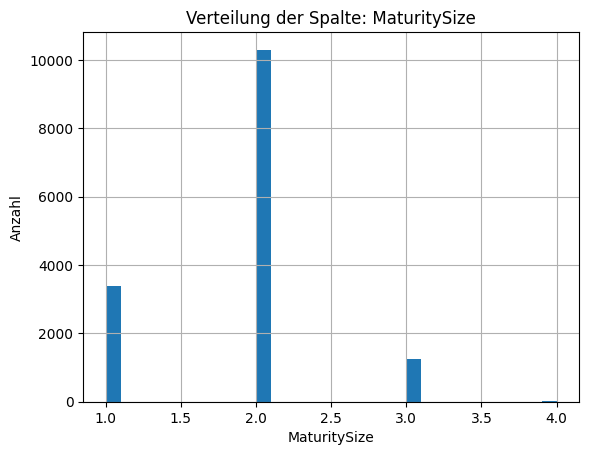

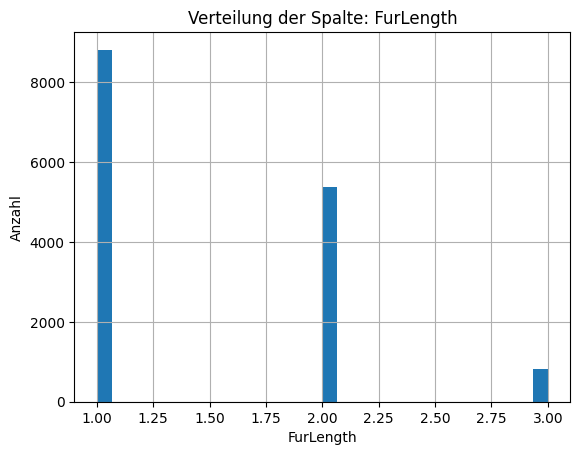

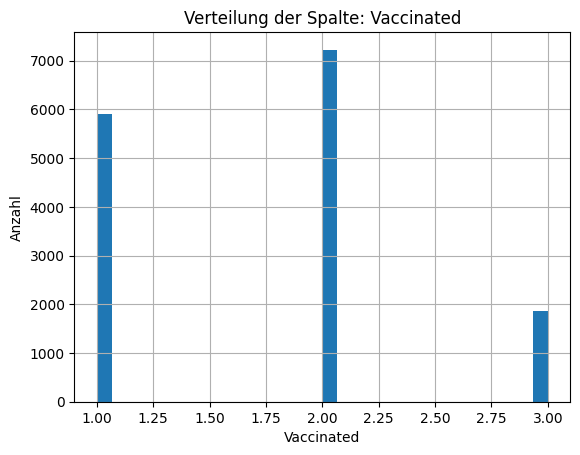

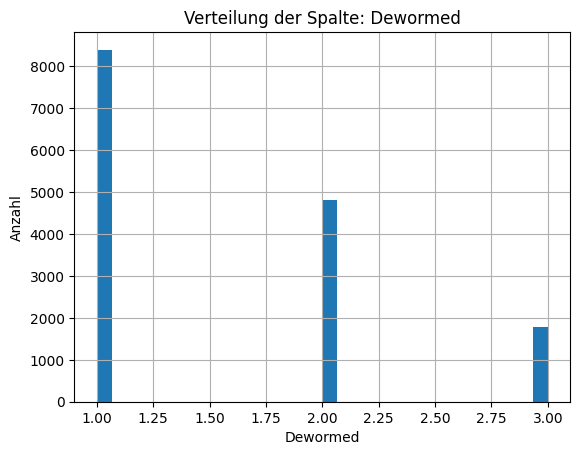

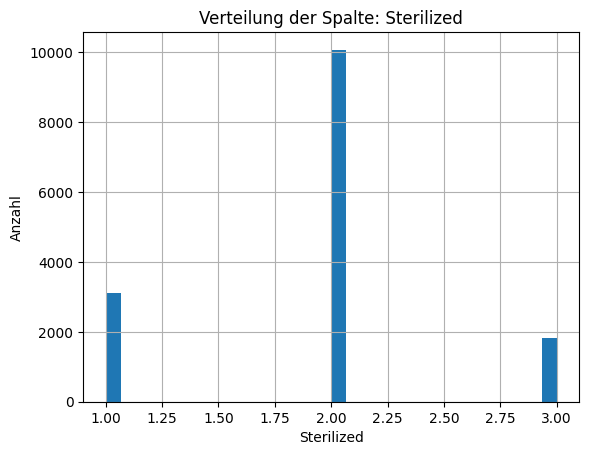

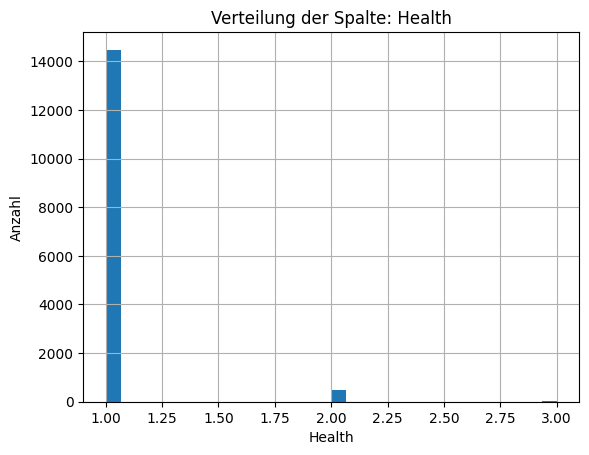

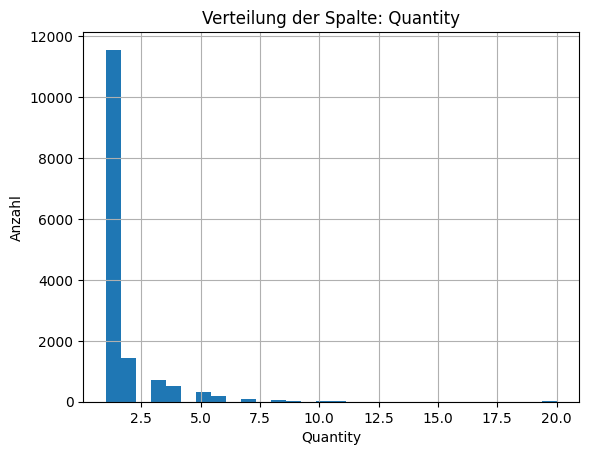

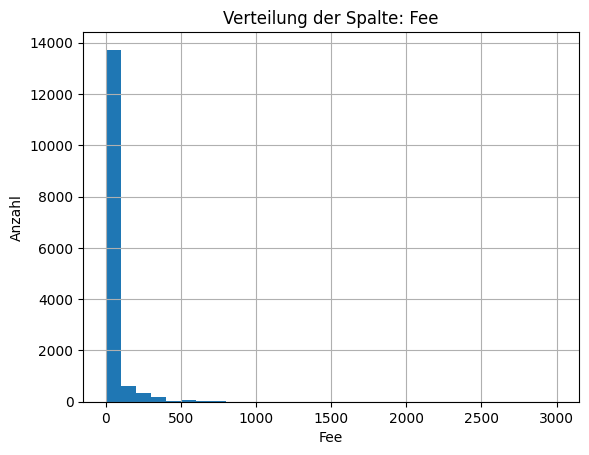

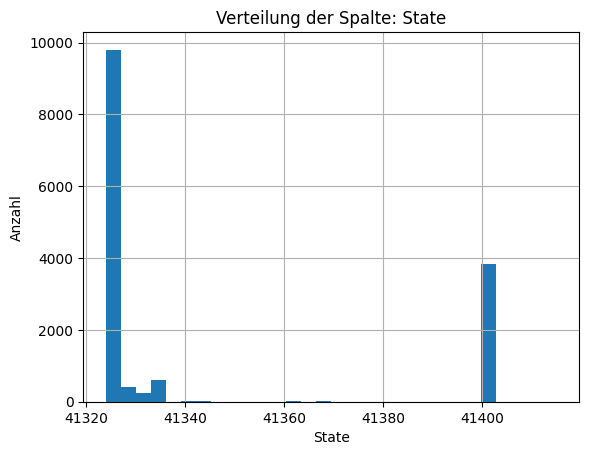

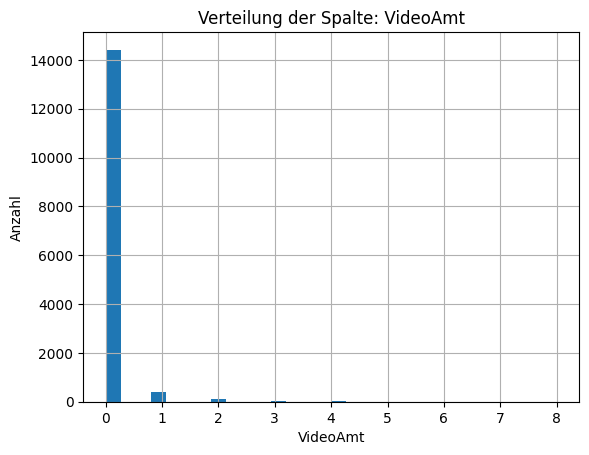

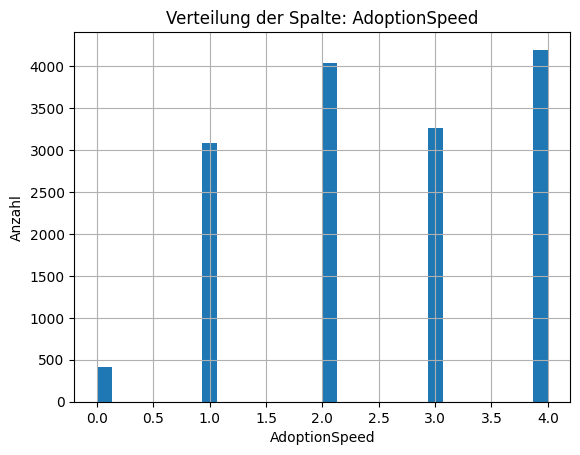

In [10]:
int_columns = combined.select_dtypes(include='int').columns

for col in int_columns:
    plt.figure()
    train[col].hist(bins=30)
    plt.title(f'Verteilung der Spalte: {col}')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.show()

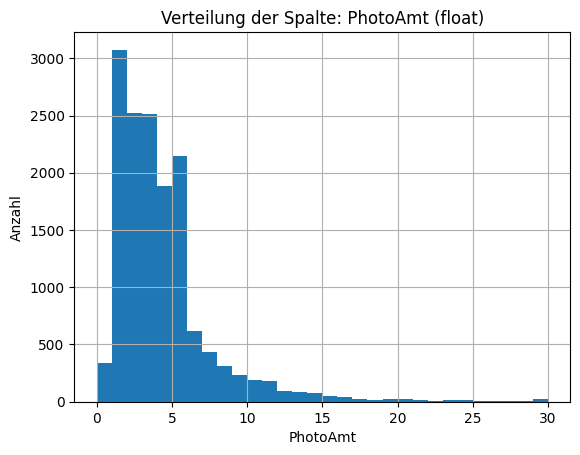

In [11]:
float_columns = combined.select_dtypes(include='float').columns

for col in float_columns:
    plt.figure()
    train[col].hist(bins=30)
    plt.title(f'Verteilung der Spalte: {col} (float)')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.show()

In [12]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           18965 non-null  int64  
 1   Age            18965 non-null  int64  
 2   Breed1         18965 non-null  int64  
 3   Breed2         18965 non-null  int64  
 4   Gender         18965 non-null  int64  
 5   Color1         18965 non-null  int64  
 6   Color2         18965 non-null  int64  
 7   Color3         18965 non-null  int64  
 8   MaturitySize   18965 non-null  int64  
 9   FurLength      18965 non-null  int64  
 10  Vaccinated     18965 non-null  int64  
 11  Dewormed       18965 non-null  int64  
 12  Sterilized     18965 non-null  int64  
 13  Health         18965 non-null  int64  
 14  Quantity       18965 non-null  int64  
 15  Fee            18965 non-null  int64  
 16  State          18965 non-null  int64  
 17  RescuerID      18965 non-null  object 
 18  VideoA

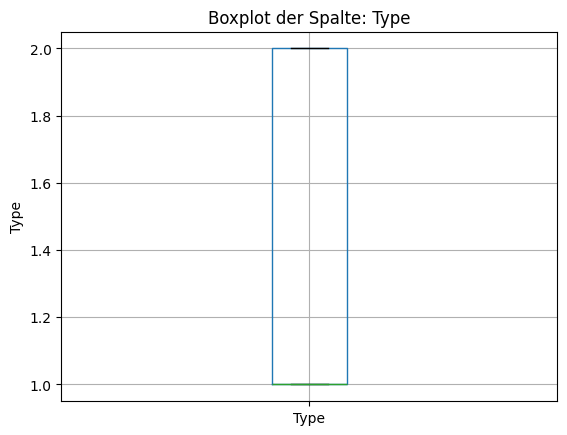

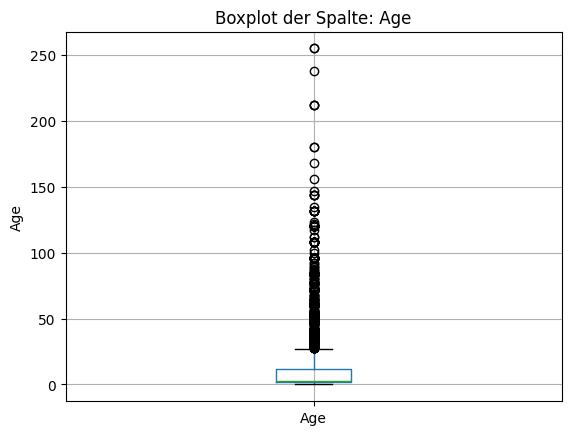

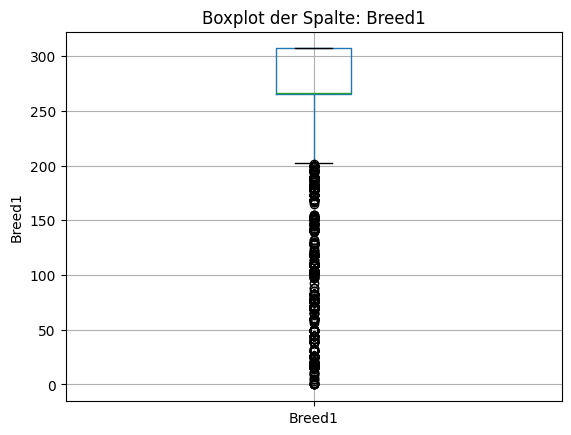

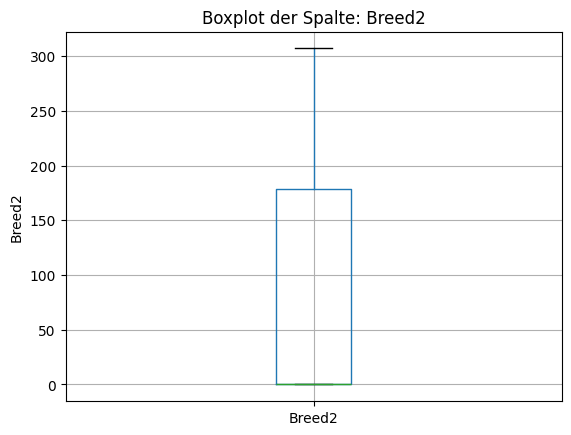

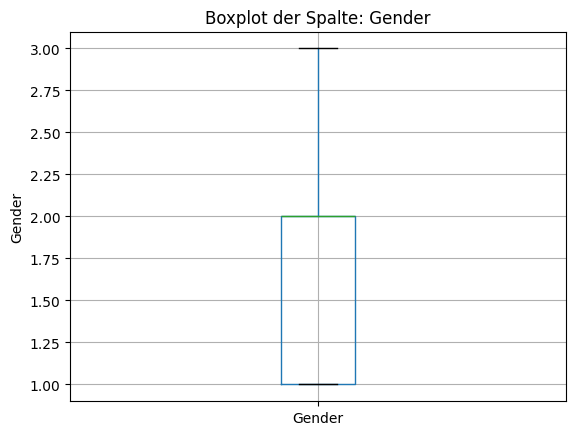

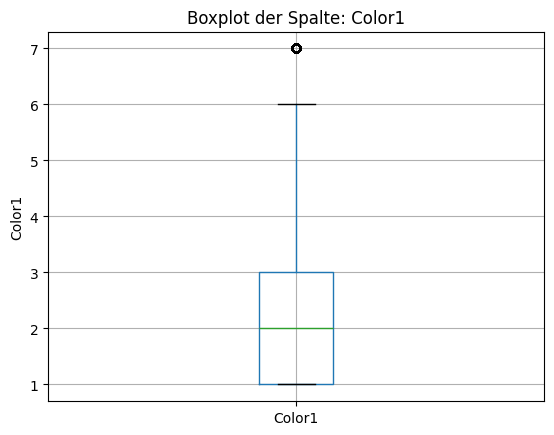

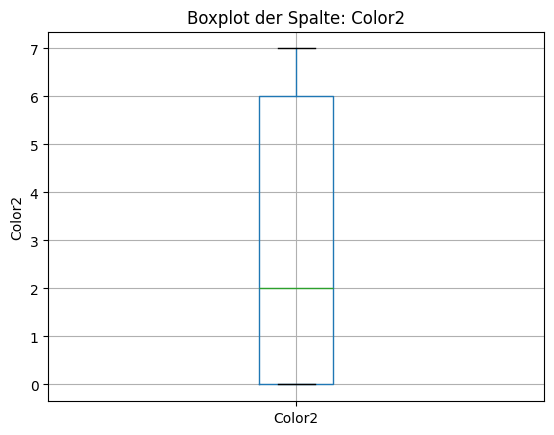

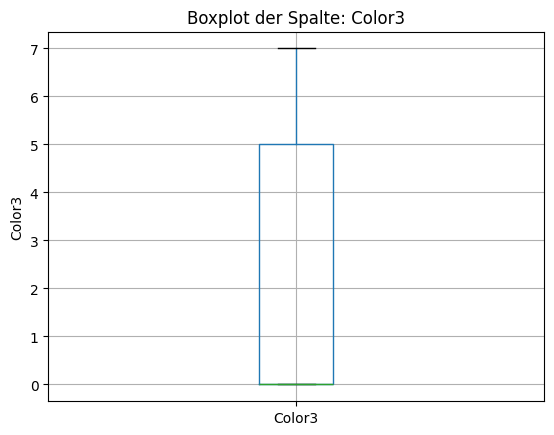

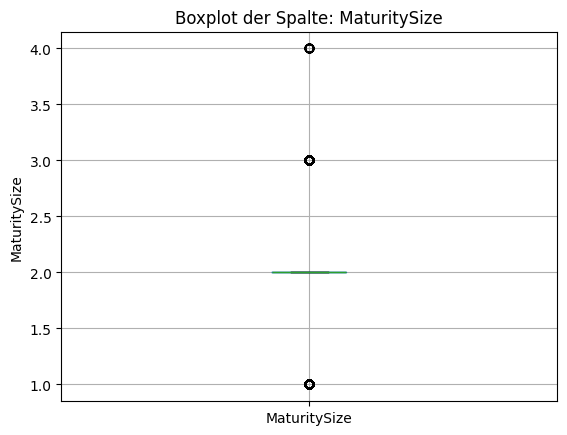

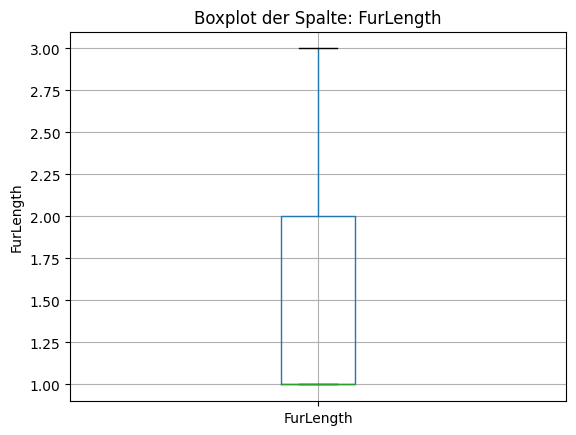

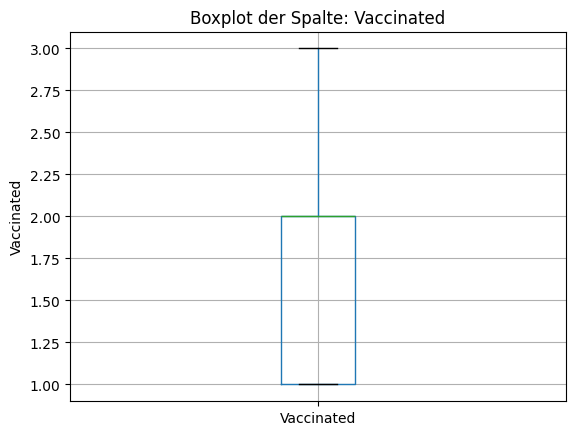

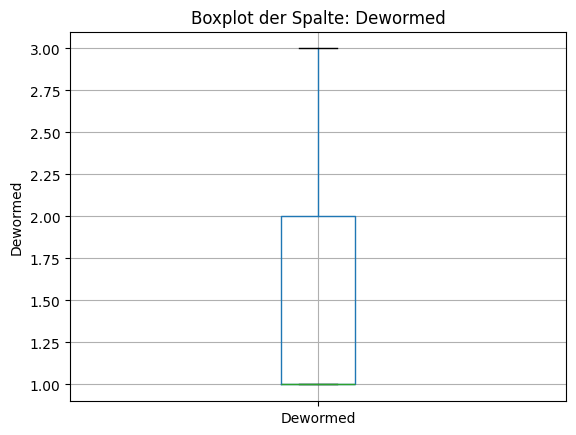

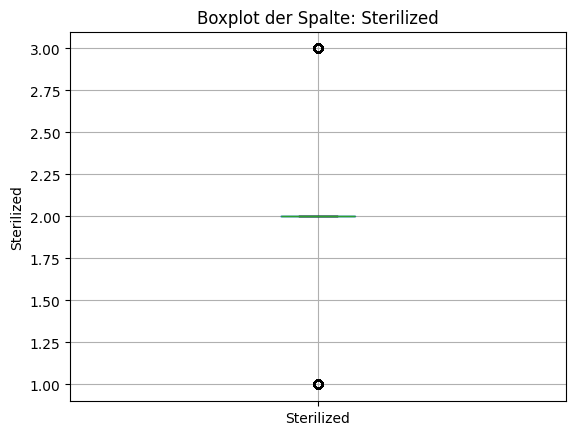

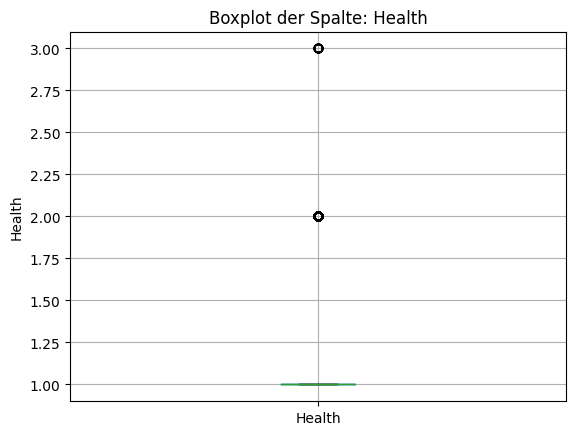

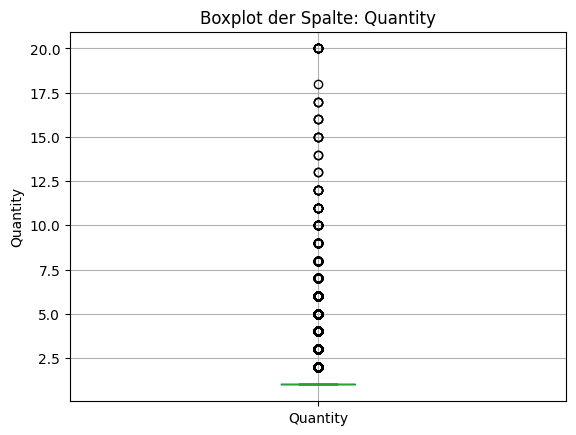

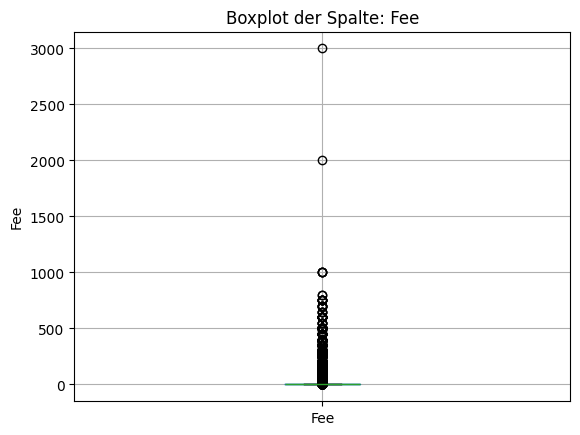

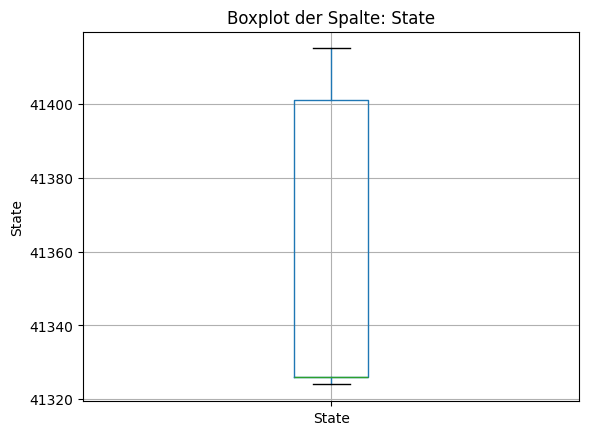

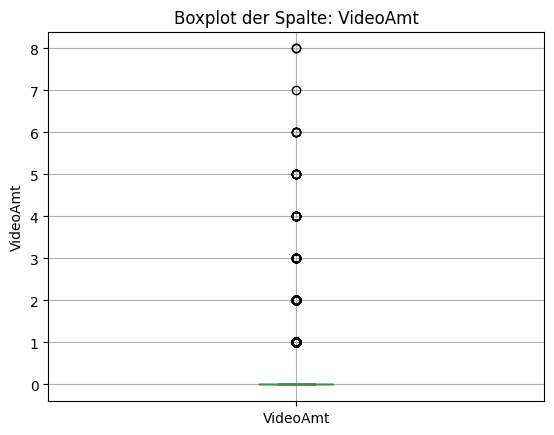

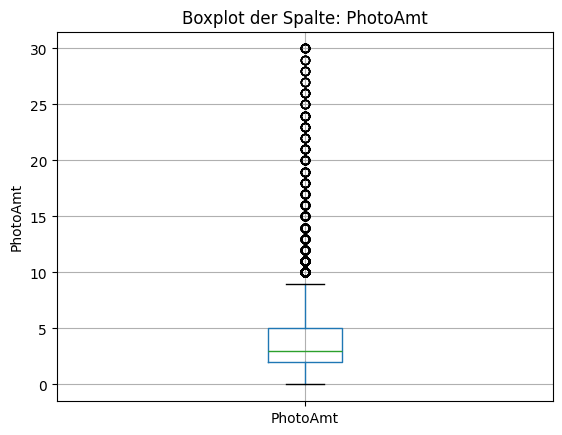

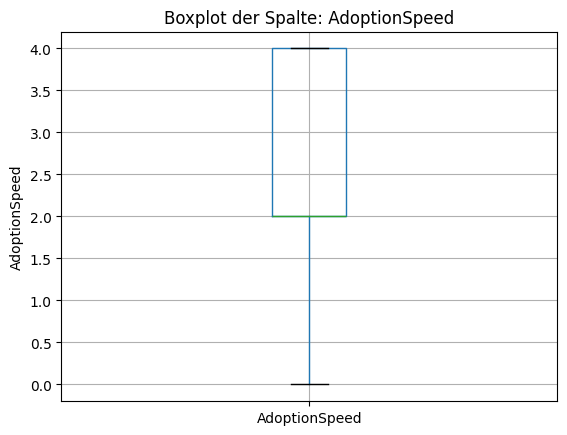

In [13]:
numeric_columns = combined.select_dtypes(include=['int', 'float'])

for col in numeric_columns:
    plt.figure()
    train.boxplot(column=col)
    plt.title(f'Boxplot der Spalte: {col}')
    plt.ylabel(col)
    plt.show()

### Description anpassen im combined df

In [14]:
combined["description_wordcount"] = combined["Description"].fillna("").apply(lambda x: len(x.split()))

In [15]:
print(combined["description_wordcount"].describe())

count    18965.000000
mean        61.956077
std         67.414538
min          0.000000
25%         20.000000
50%         44.000000
75%         80.000000
max       1257.000000
Name: description_wordcount, dtype: float64


In [16]:
combined['description_wordcount']

0        69
1        23
2        69
3        25
4        81
         ..
18960    21
18961    24
18962    34
18963    19
18964     9
Name: description_wordcount, Length: 18965, dtype: int64

In [17]:
combined = combined.drop(columns=['Description'])

In [18]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   18965 non-null  int64  
 1   Age                    18965 non-null  int64  
 2   Breed1                 18965 non-null  int64  
 3   Breed2                 18965 non-null  int64  
 4   Gender                 18965 non-null  int64  
 5   Color1                 18965 non-null  int64  
 6   Color2                 18965 non-null  int64  
 7   Color3                 18965 non-null  int64  
 8   MaturitySize           18965 non-null  int64  
 9   FurLength              18965 non-null  int64  
 10  Vaccinated             18965 non-null  int64  
 11  Dewormed               18965 non-null  int64  
 12  Sterilized             18965 non-null  int64  
 13  Health                 18965 non-null  int64  
 14  Quantity               18965 non-null  int64  
 15  Fe

# Spalten anpassen

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combined["RescuerID"] = le.fit_transform(combined["RescuerID"].astype(str))

In [20]:
# Bearbeiteter df speichern
combined.to_csv("Data/preprocessed/combined_preprocessed.csv", index=False)


In [21]:
from sklearn.model_selection import train_test_split

# Erst in train und temp splitten
train_df, temp_df = train_test_split(combined, test_size=0.3, random_state=42)

# Dann temp in valid und test splitten
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Train: 13275, Valid: 2845, Test: 2845


In [22]:
# Zielvariable für Validierung und Test extrahieren
valid_target = valid_df[["PetID", "AdoptionSpeed"]].copy()
test_target = test_df[["PetID", "AdoptionSpeed"]].copy()

# AdoptionSpeed aus den Features entfernen
valid_df = valid_df.drop(columns=["AdoptionSpeed"])
test_df = test_df.drop(columns=["AdoptionSpeed"])

In [23]:
# df's speichern
train_df.to_csv("Data/preprocessed/train_preprocessed.csv", index=False)
valid_df.to_csv("Data/preprocessed/valid_preprocessed.csv", index=False)
test_df.to_csv("Data/preprocessed/test_preprocessed.csv", index=False)
valid_target.to_csv("Data/preprocessed/valid_target.csv", index=False)
test_target.to_csv("Data/preprocessed/test_target.csv", index=False)